In [1]:
import torch
from transformers import (
    XLNetTokenizer,
    XLNetLMHeadModel,
    LineByLineTextDataset,
    DataCollatorForPermutationLanguageModeling,
)
from transformers import Trainer, TrainingArguments

import wandb

# initialize wandb
wandb.init(project="xlnet-training", name="xlnet-training-run")


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: scaredmeow. Use `wandb login --relogin` to force relogin


In [2]:
tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")
pad_token = tokenizer.pad_token

# Read the text file and split it into lines
with open("../data/model-data/wikitext-tl-39/train.txt", "r") as f:
    lines = f.read().splitlines()

# Add padding tokens to odd-length lines
padded_lines = []
for line in lines:
    tokens = tokenizer.tokenize(line)
    if len(tokens) % 2 == 1:
        tokens.append(pad_token)
    padded_line = tokenizer.convert_tokens_to_string(tokens)
    padded_lines.append(padded_line)

# Write the padded lines to a new text file
with open("../data/model-data/wikitext-tl-39/train_padded.txt", "w") as f:
    for line in padded_lines:
        f.write(line + "\n")

# Create the LineByLineTextDataset using the new text file
train_dataset = LineByLineTextDataset(
    tokenizer=tokenizer,
    file_path="../data/model-data/wikitext-tl-39/train_padded.txt",
    block_size=512,
)


c:\Users\Neilc\dev\proj\nlp-thesis-xlnet-tagalog\.venv\lib\site-packages\transformers\data\datasets\language_modeling.py:119: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


In [3]:
# define your data collator for permutation language modeling
data_collator = DataCollatorForPermutationLanguageModeling(
    tokenizer=tokenizer,
    plm_probability=0.15,
)


In [4]:
# define your model
model = XLNetLMHeadModel.from_pretrained("xlnet-base-cased")

# set the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


XLNetLMHeadModel(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0-11): 12 x XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (lm_loss): Linear(in_features=768, out_features=32000, bias=True)
)

In [5]:
training_args = TrainingArguments(
    output_dir="../models/pretrained-xlnet",
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=16,  # Use gradient accumulation to simulate a larger batch size
    learning_rate=5e-5,
    weight_decay=0.01,
    adam_epsilon=1e-8,
    max_grad_norm=0.5,
    warmup_steps=0,
    logging_dir="./logs",
    logging_steps=500,
    save_steps=500,
    save_total_limit=2,
)


In [6]:
from transformers.integrations import WandbCallback

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    data_collator=data_collator,
    callbacks=[WandbCallback()],
)


You are adding a <class 'transformers.integrations.WandbCallback'> to the callbacks of this Trainer, but there is already one. The currentlist of callbacks is
:DefaultFlowCallback
WandbCallback


In [7]:
trainer.train()


c:\Users\Neilc\dev\proj\nlp-thesis-xlnet-tagalog\.venv\lib\site-packages\transformers\optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/47627 [00:00<?, ?it/s]

{'loss': 4.4309, 'learning_rate': 4.947508766036072e-05, 'epoch': 0.01}
{'loss': 3.7872, 'learning_rate': 4.895017532072144e-05, 'epoch': 0.02}
{'loss': 3.5007, 'learning_rate': 4.842526298108216e-05, 'epoch': 0.03}
{'loss': 3.3514, 'learning_rate': 4.790035064144288e-05, 'epoch': 0.04}
{'loss': 3.2684, 'learning_rate': 4.73754383018036e-05, 'epoch': 0.05}
{'loss': 3.1476, 'learning_rate': 4.685052596216432e-05, 'epoch': 0.06}
{'loss': 3.0828, 'learning_rate': 4.632561362252504e-05, 'epoch': 0.07}
{'loss': 3.0645, 'learning_rate': 4.580070128288576e-05, 'epoch': 0.08}
{'loss': 3.0493, 'learning_rate': 4.5275788943246476e-05, 'epoch': 0.09}
{'loss': 2.9792, 'learning_rate': 4.47508766036072e-05, 'epoch': 0.1}
{'loss': 2.9089, 'learning_rate': 4.422596426396792e-05, 'epoch': 0.12}
{'loss': 2.8264, 'learning_rate': 4.370105192432864e-05, 'epoch': 0.13}
{'loss': 2.7604, 'learning_rate': 4.3176139584689356e-05, 'epoch': 0.14}
{'loss': 2.7492, 'learning_rate': 4.265122724505008e-05, 'epoch':

TrainOutput(global_step=47627, training_loss=2.391273834454705, metrics={'train_runtime': 145742.6043, 'train_samples_per_second': 10.457, 'train_steps_per_second': 0.327, 'train_loss': 2.391273834454705, 'epoch': 1.0})

In [8]:
trainer.save_model("../models/pretrained-xlnet-1st-iter")


In [31]:
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer


pretrained = "../models/fine-tuned-xlnet-1st-iter"
model2 = AutoModelForSequenceClassification.from_pretrained(
    pretrained, num_labels=5
).to(device)
tokenizer = AutoTokenizer.from_pretrained("xlnet-base-cased")


In [33]:
from transformers import pipeline

classifier = pipeline(
    "sentiment-analysis",
    model=model2,
    tokenizer=tokenizer,
)


In [34]:
import pandas as pd

train = pd.read_csv("../data/dataset/train.csv")
test = pd.read_csv("../data/dataset/test.csv")
validation = pd.read_csv("../data/dataset/validation.csv")


In [35]:
pred = classifier(train.text.tolist())

train["label"] = train["0"].replace({1: 2})
train["label"] = train.apply(lambda x: x["label"] + x["1"], axis=1).replace({1: 3})
train["label"] = train.apply(lambda x: x["label"] + x["2"], axis=1).replace({1: 4})
train["label"] = train.apply(lambda x: x["label"] + x["3"], axis=1).replace({1: 5})
train["label"] = train.apply(lambda x: x["label"] + x["4"], axis=1).replace({1: 6})

train["label"] = train["label"].apply(lambda x: x - 2)

y_true = train.label.tolist()
y_pred = []

train


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [16]:
validation["label"] = validation["0"].replace({1: 2})
validation["label"] = validation.apply(lambda x: x["label"] + x["1"], axis=1).replace(
    {1: 3}
)
validation["label"] = validation.apply(lambda x: x["label"] + x["2"], axis=1).replace(
    {1: 4}
)
validation["label"] = validation.apply(lambda x: x["label"] + x["3"], axis=1).replace(
    {1: 5}
)
validation["label"] = validation.apply(lambda x: x["label"] + x["4"], axis=1).replace(
    {1: 6}
)

validation["label"] = validation["label"].apply(lambda x: x - 2)

y_true = validation.label.tolist()


In [24]:
pred


[{'label': 'LABEL_0', 'score': 0.6974449157714844},
 {'label': 'LABEL_0', 'score': 0.7322133183479309},
 {'label': 'LABEL_0', 'score': 0.6944235563278198},
 {'label': 'LABEL_0', 'score': 0.7060639262199402},
 {'label': 'LABEL_0', 'score': 0.714000940322876},
 {'label': 'LABEL_0', 'score': 0.6979614496231079},
 {'label': 'LABEL_0', 'score': 0.7119072675704956},
 {'label': 'LABEL_0', 'score': 0.6752827167510986},
 {'label': 'LABEL_0', 'score': 0.7336578965187073},
 {'label': 'LABEL_0', 'score': 0.6830052733421326},
 {'label': 'LABEL_0', 'score': 0.7229909300804138},
 {'label': 'LABEL_0', 'score': 0.6753230094909668},
 {'label': 'LABEL_0', 'score': 0.7659703493118286},
 {'label': 'LABEL_0', 'score': 0.7036061882972717},
 {'label': 'LABEL_0', 'score': 0.6925311088562012},
 {'label': 'LABEL_0', 'score': 0.6894550919532776},
 {'label': 'LABEL_0', 'score': 0.6888996362686157},
 {'label': 'LABEL_0', 'score': 0.7253677248954773},
 {'label': 'LABEL_0', 'score': 0.6813867688179016},
 {'label': 'L

In [21]:
y_pred = []


In [22]:
for i in pred:
    y_pred.append(int(i["label"][-1]))

print(f"{len(y_true)} : pred {len(y_pred)}")


2250 : pred 2250


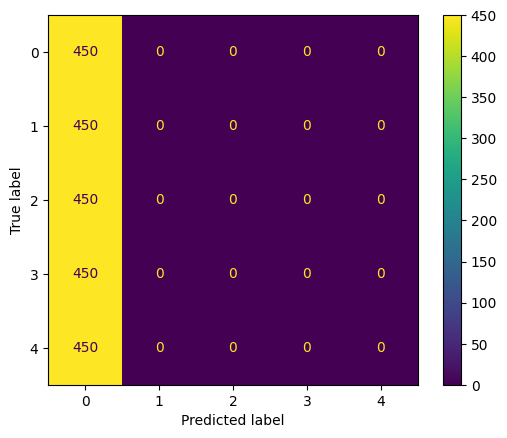

Accuracy: 0.2
Precision: 0.04
Recall: 0.2
F1 score: 0.06666666666666668


c:\Users\Neilc\dev\proj\nlp-thesis-xlnet-tagalog\.venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    log_loss,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4])
disp.plot()
plt.show()

# Compute the accuracy
acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)

# Compute the precision
prec = precision_score(y_true, y_pred, average="macro")
print("Precision:", prec)

# Compute the recall
rec = recall_score(y_true, y_pred, average="macro")
print("Recall:", rec)

# Compute the f1 score
f1 = f1_score(y_true, y_pred, average="macro")
print("F1 score:", f1)

# # Compute the log-loss
# ll = log_loss(y_true, y_pred, labels=[0, 1, 2, 3, 4])
# print("Log-loss:", ll)

# # Compute the AUC-ROC
# auc = roc_auc_score(y_true, y_pred, average="macro", multi_class="ovr")
# print("AUC-ROC:", auc)
